In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Data science on responses to Automatique & Santé questionnaire
Action GDR MACS, Jérome Cieslak, Antoine Chaillet, JJ Aucouturier &copy; 2022

## Data from _Manifestation d'intérêt_ 

In [2]:
manifest_df = pd.read_csv('data/manifestation_interet.csv', encoding='latin1')

### Rename columns

In [3]:
manifest_df = manifest_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom?':'last_name',
                                          'Quel est votre prénom?':'first_name', 
                                          'Si oui, dans quel domaine applicatif ? ':'clinical_domains',
                                          'Au travers de quels outils méthodologiques ?':'control_domains',
                                          'Si ces travaux ont déjà donné lieu à des publications, merci de nous en donner la liste:':'publication_list',
                                          'Sur le principe, seriez-vous intéressé par les actions suivantes (cette réponse ne constitue en rien un engagement de votre part!)':'interests',
                                          "Connaissez-vous des collègues (en France) dont les activités de recherche relèvent des outils de l'automatique utilisés pour la santé?":'recommendations',
                                          'Des suggestions ? Des remarques ?':'remarks'
                           })
manifest_df = manifest_df.drop(columns=['Avez-vous déjà travaillé sur des thématiques liant Automatique et Santé ou comptez-vous aborder de telles questions ?'])

### Parse categories from multiple-choice questions

#### Clinical domains

In [4]:
# split list in each column and explode as separate rows 
manifest_df.clinical_domains = manifest_df.clinical_domains.str.split(',')
manifest_df = manifest_df.explode('clinical_domains')

In [5]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Neuroscience':'Neurosciences',
          'Système cardio-respiratoire':'Cardio-respiratoire',
          'Cancérologie':'Cancer',
          ' Anésthesie':'Anesthésie',
          ' Respiration artificielle':'Cardio-respiratoire',
          ' Diabète':'Diabète',
          ' Cancérologie':'Cancer',
          'Diabète':'Diabète',
          ' Système cardio-respiratoire':'Cardio-respiratoire',
          ' modélisation muscle':'Mouvement & Musculo-squelettique',
          ' Méditation':'Méditation',
          'Anesthésie':'Anesthésie'}
manifest_df.clinical_domains = manifest_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   


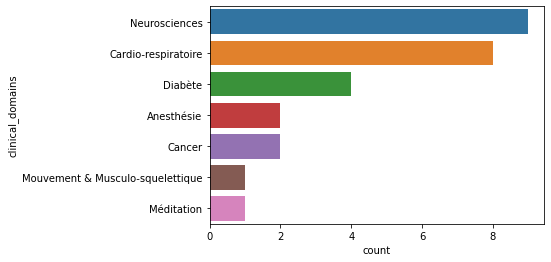

In [6]:
sns.countplot(y="clinical_domains", 
              order = manifest_df.groupby(['clinical_domains']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).clinical_domains,
              
              data=manifest_df)

In [7]:
manifest_df[manifest_df.clinical_domains=='Diabète']['last_name'].unique()

array(['Laleg', 'Magdelaine', 'Mounier', 'RICHARD'], dtype=object)

#### Control domains

In [8]:
# split list in each column and explode as separate rows 
manifest_df.control_domains = manifest_df.control_domains.str.split(',')
manifest_df = manifest_df.explode('control_domains')

In [9]:
# rename duplicates: white space and accents
rename_control_domains = {'Modélisation':'Modélisation',
                          ' Identification':'Identification',
                          'Identification':'Identification',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Analyse':'Analyse',
                          ' Traitement du signal ':'Traitement du signal',
                          'Observateurs':'Observateurs',
                          'Commande':'Commande',
                          'Analyse':'Analyse'}
manifest_df.control_domains = manifest_df.control_domains.apply(lambda row: rename_control_domains[row])   


In [10]:
manifest_df.groupby(['control_domains']).last_name.count()

control_domains
Analyse                 11
Commande                21
Identification          17
Modélisation            21
Observateurs            14
Traitement du signal     4
Name: last_name, dtype: int64

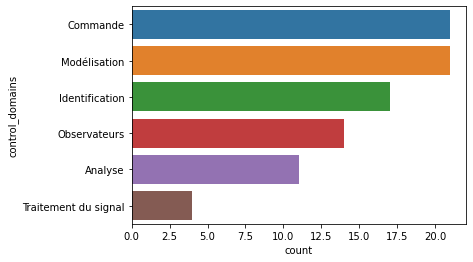

In [11]:
sns.countplot(y="control_domains", 
              order = manifest_df.groupby(['control_domains']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).control_domains,
              data=manifest_df)

#### Interests

In [12]:
# split list in each column and explode as separate rows 
manifest_df.interests = manifest_df.interests.str.replace(';',',') # some choices are semi-colon separated
manifest_df.interests = manifest_df.interests.str.split(',')
manifest_df = manifest_df.explode('interests')

In [13]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_interests = {"Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la santé":'informé par email',
                    ' Participer à des journées scientifiques dédiées':'participer journées scientifiques',
       ' Contribuer à des publications communes (livre blanc': 'participer à des publications',
       ' vulgarisation':np.nan,
        ' survey':np.nan,
        ' conférences':np.nan,
                    ' journaux':np.nan,
                    '...)':np.nan,
       " toute action facilitant l'accès à des practiciens hospitaliers pour conduire des tests cliniques": 'faciliter accès aux médecins',
       ' toute action permettant de trouver des étudiants candidats à stages de master et thèse sur la thématique. . ':'faciliter recrutement étudiants',
       ' Avoir accès à un site web recensant les activités sur ce thèmes':'site web dédié',
        ' Accès aux données':'faciliter accès aux données',
        ' créer une base de données pour échange':'faciliter accès aux médecins',
                    ' opportunités de collaborations aves des médecins':np.nan,
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés'}
manifest_df.interests = manifest_df.interests.apply(lambda row: rename_interests[row])   

# drop nans
manifest_df = manifest_df.dropna(subset=['interests'])


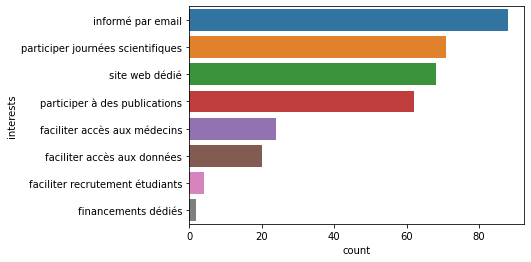

In [14]:
sns.countplot(y="interests",
              order = manifest_df.groupby(['interests']).last_name.nunique().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).interests,
              data=manifest_df)

<mark> TODO: check y-axis number </mark>

## Data from _Questionnaire_ 

In [32]:
question_df = pd.read_csv('data/reponses_20_07_2022.csv', encoding='latin1')

In [33]:
# drop columns that are all na
question_df = question_df.dropna(axis='columns',how='all')

### Rename columns

In [34]:
# give clean names
question_df = question_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom ?':'last_name',
                                          'Quel est votre prÃ©nom ?':'first_name', 
                                          'Quel est votre adresse mail?':'email',
                                          'Quel est votre statut?.2':'position',
                                          'Quel est votre employeur?':'employer',
                                          'Au travers de quels outils mÃ©thodologiques?':'control_domains',
                                          'Avec quel(le)s praticien(ne)s hospitalier(e)s (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous (service, hÃ´pital, adresse mail bienvenue) ?':'doctor_list',
                                          'Quel est votre laboratoire?':'affiliation',
                                          "Si oui, il s'agit de l'automatique pour?":'clinical_domains',
                                          'Au travers de quel type de financement?':'funding',
                                          'Si ces travaux ont dÃ©jÃ\xa0 donnÃ© lieu Ã\xa0 des publications, merci de nous en donner la liste:.1':'publication_list',
                                          'Seriez-vous intÃ©ressÃ© par les actions suivantes:.2':'interests',
                                          'Avec quels acteurs industriels (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous sur ces applications (nom, adresse mail bienvenue) ?':'industry_list',
                                          'Avec quel(le)s collÃ¨gues non automaticien(ne)s (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous (ou envisagez-vous de travailler) sur ces thÃ©matiques (nom, adresse mail bienvenue) ?':'non_control_collaborators',
                                          'Selon vous, quels sont les principaux freins Ã\xa0 une recherche interdisciplinaire mÃªlant automatique & santÃ© ?.3':'pain_points',
                                          'Selon vous, quels sont les acteurs majeurs (au niveau mondial) sur la recherche en Automatique au service de la santÃ© ?.1':'international_best',
                                          'Des suggestions ? Des remarques ?.1':'remarks'})
question_df = question_df.drop(columns=['Avez-vous dÃ©jÃ\xa0 travaillÃ© sur des thÃ©matiques liant Automatique et SantÃ© ou comptez-vous aborder de telles questions ?'])

In [35]:
question_df

,date,first_name,email,position,employer,control_domains,doctor_list,affiliation,last_name,clinical_domains,funding,publication_list,interests,industry_list,non_control_collaborators,pain_points,international_best,remarks
0,16/05/2022 09:42:46,Antoine,antoine.chaillet@centralesupelec.fr,PU,Ecole d'ingÃ©nieurs CentraleSupÃ©lec,"ModÃ©lisation, Analyse, Commande, Observateurs","Suhan Senova, hopital Henri Mondor de CrÃ©teil...",L2S,Chaillet,Les neurosciences ou la psychatrie,"RÃ©gional, National (ANR, ...)","Faillot, M., Chaillet, A., Palfi, S., & Senova...",Etre informÃ© par mail sur des actions scienti...,"Medtronic, Boston Scientific","Alain Destexhe, NeuroPSI, alain.destexhe@cnrs...",Lourdeur administrative pour achat de matÃ©rie...,Rodolphe Sepulchre (Cambridge),Super ce questionnaire !
1,17/05/2022 08:54:03,Jean-FranÃ§ois,jean-francois.duhe@ims-bordeaux.fr,Doctorant,UniversitÃ©,"ModÃ©lisation, Identification","HÃ´pital du Haut L'Ã©vÃªque, avec Youssef Abde...",IMS Bordeaux,DuhÃ©,Le systÃ¨me cardio-respiratoire (ex: respirate...,RÃ©gional,"La liste est un peu longue, mais je peux bien ...",Participer Ã des journÃ©es scientifiques dÃ©d...,aucun,StÃ©phane Victor et Pierre Melchior stephane.v...,"manque de financement, manque d'ouverture d'es...",aucune idÃ©e malheureusement,dans la question des freins Ã la recherche in...
2,17/05/2022 08:59:39,Guillaume,guillaume.bouleux@insa-lyon.fr,MaÃ®tre de confÃ©rences,UniversitÃ©,"ModÃ©lisation, Identification, Analyse","Olivier Mory, CHU d Staint Etienne",DISP,Bouleux,L'Ã©pidÃ©miologie ou la santÃ© environnemental...,"National (ANR, ...)",NaN,Etre informÃ© par mail sur des actions scienti...,NaN,ValÃ©rie Dos Santos Martins (valerie.dos-santo...,NaN,NaN,NaN
3,17/05/2022 09:00:47,Mazen,mazen.alamir@grenooble-inp.fr,DR,CNRS,"ModÃ©lisation, Commande",Michel Mazerolles (CHU Tulouse),GIPSA-lab,ALAMIR,"Les neurosciences ou la psychatrie, La cancÃ©r...","National (ANR, ...)","Alamir, M. and Chareyron, S. State Constrained...",Etre informÃ© par mail sur des actions scienti...,--,--,NaN,--,--
4,17/05/2022 09:06:27,Najib,najib.essounbouli@univ-reims.fr,PU,UniversitÃ©,Commande,NaN,CResTIC,ESSOUNBOULI,Le diabÃ¨te,sans projet puisque nous avons dÃ©butÃ© cette ...,"Tarek Aounallah, Najib Essounbouli, Abdelaziz ...",Etre informÃ© par mail sur des actions scienti...,NaN,NaN,les praticiens sont trÃ¨s sollicitÃ©s et il es...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,13/06/2022 13:05:29,Aude,aude.bolopion@femto-st.fr,CR,CNRS,"Commande, Observateurs","EFS de Bourgogne Franche ComtÃ©, Institut Pasteur",Institut FEMTO-ST,Bolopion,La cancÃ©rologie,"RÃ©gional, National (ANR, ...)","H. Daguerre, S. O. Demir, U. Culha, F. Marionn...",Avoir accÃ¨s Ã un site web recensant les acti...,NaN,Federica Caselli (Rome),NaN,NaN,NaN
70,30/06/2022 16:58:42,Bogdan,bogdan.robu@gipsa-lab.fr,MaÃ®tre de confÃ©rences,UniversitÃ©,"ModÃ©lisation, Identification, Analyse, Machin...",NaN,GIPSA-lab,Robu,apprentissage ML sur des EEG pour dÃ©tecter la...,"National (ANR, ...)",NaN,Etre informÃ© par mail sur des actions scienti...,NaN,NaN,Financement,NaN,NaN
71,30/06/2022 18:16:28,Ihab,ihab.haidar@ensea.fr,MaÃ®tre de confÃ©rences,ENSEA,"ModÃ©lisation, Analyse, Commande, Observateurs",NaN,Quartz,Haidar,"Les neurosciences ou la psychatrie, La biochim...",NaN,NaN,Etre informÃ© par mail sur des actions scienti...,NaN,NaN,NaN,NaN,NaN
72,04/07/2022 08:45:35,CÃ©dric,cedric.join@univ-lorraine.fr,PU,UniversitÃ©,Commande,NaN,CRAN,Join,"Le diabÃ¨te, La cancÃ©rologie, L'Ã©pidÃ©miolog...",NaN,Toward more realistic social distancing polici...,Etre informÃ© par mail sur des actions scienti...,NaN,NaN,Les questions qui prÃ©cÃ©dent rÃ©pondent Ã ce...,NaN,NaN


### Fix duplicates

#### Position

In [36]:
question_df.position.unique()

array(['PU', 'Doctorant', 'MaÃ®tre de confÃ©rences', 'DR', 'Post-Doc',
       'DR Ã©mÃ©rite', 'CR', 'ITA (ex. IE, IR)', 'professeur',
       'PU Ã©mÃ©rite', 'Assistant Professor', 'Enseignant Chercheur',
       'Je ne connais pas son statut (enseignant-chercheur)',
       'IngÃ©nieur de recherche'], dtype=object)

In [37]:
# rename duplicates: some values include white space or different accents
rename_position = {'PU':'PU/Professor',
                   'Doctorant':'PhD student',
                   'MaÃ®tre de confÃ©rences':'MCU/Assistant Professor',
                   'DR':'Directeur de recherche',
                   'Post-Doc':'Postdoc',
                   'DR Ã©mÃ©rite':'Emeritus',
                   'CR':'Chargé de recherche',
                   'ITA (ex. IE, IR)':'Ingénieur Etude/Recherche',
                   'professeur':'PU/Professor',
                   'PU Ã©mÃ©rite':'Emeritus',
                   'Assistant Professor':'MCU/Assistant Professor', 
                   'Enseignant Chercheur':'MCU/Assistant Professor',
                   'Je ne connais pas son statut (enseignant-chercheur)':np.nan,
                   'IngÃ©nieur de recherche':'Ingénieur Etude/Recherche'}
question_df.position = question_df.position.apply(lambda row: rename_position[row]) 

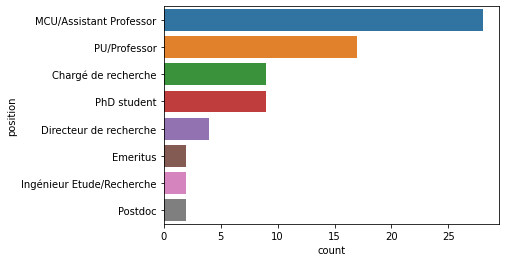

In [38]:
sns.countplot(y="position",
              order = question_df.groupby(['position']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).position,
              data=question_df)

#### Employer

In [39]:
question_df.employer.unique()

array(["Ecole d'ingÃ©nieurs CentraleSupÃ©lec", 'UniversitÃ©', 'CNRS',
       'CEGEDIM Groupe', 'Grenoble-INP', 'CentraleSupÃ©lec',
       'IRT Jules Verne', 'IMT Mines Ales', 'Centrale Nantes',
       'ENS Paris-Saclay', 'CHU 80% / Centrale 20%', 'Grand Ecole',
       'Bordeaux INP', 'ISAE-SUPAERO', 'ESTIA', 'INRIA', 'ENSMM',
       'ENSMM (SupMicroTech)', 'ONERA', 'ENSEA'], dtype=object)

In [40]:
# rename duplicates: 
rename_employer = {"Ecole d'ingÃ©nieurs CentraleSupÃ©lec": "Ecole d'ingénieur",
                   'UniversitÃ©':'Université',
                   'CNRS':'CNRS',
                   'CEGEDIM Groupe':'Industry',
                   'Grenoble-INP':"Ecole d'ingénieur",
                   'CentraleSupÃ©lec':"Ecole d'ingénieur",
                   'IRT Jules Verne':"Ecole d'ingénieur",
                   'IMT Mines Ales':"Ecole d'ingénieur",
                   'Centrale Nantes':"Ecole d'ingénieur",
                   'ENS Paris-Saclay':"Ecole d'ingénieur",
                   'CHU 80% / Centrale 20%':'Hospital',
                   'Grand Ecole':"Ecole d'ingénieur",
                   'Bordeaux INP':"Ecole d'ingénieur",
                   'ISAE-SUPAERO':"Ecole d'ingénieur",
                   'ESTIA':"Ecole d'ingénieur",
                   'INRIA':'INRIA',
                   'ENSMM':"Ecole d'ingénieur",
                   'ENSMM (SupMicroTech)':"Ecole d'ingénieur",
                   'ONERA':'ONERA',
                   'ENSEA':"Ecole d'ingénieur"}
question_df.employer = question_df.employer.apply(lambda row: rename_employer[row]) 

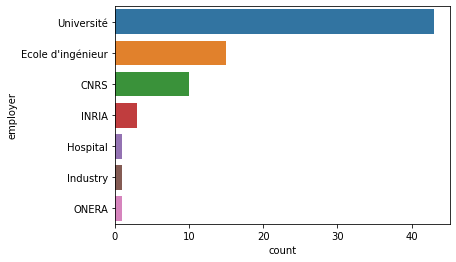

In [41]:
sns.countplot(y="employer",
              order = question_df.groupby(['employer']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).employer,
              data=question_df)

#### Affiliation

In [42]:
question_df.affiliation.unique()

array(['L2S', 'IMS Bordeaux', 'DISP', 'GIPSA-lab', 'CResTIC',
       'Laboratoire GÃ©nie et MatÃ©riaux Textiles (GEMTEX)',
       'LISSI EA 3956', 'LAMIH', 'gipsa-lab', 'LIS (Caen)', 'LIMOS',
       'IMS', 'LS2N UMR 6004 CNRS', 'AmpÃ¨re (UMR 5005)', 'CRAN', 'LS2N',
       'CERIS/PFM', 'LAMIH UMR CNRS 8201', 'ECN/LS2N UMR 6004', 'LURPA',
       'GIPSA-Lab', 'ESTAS', 'AmpÃ¨re UMR CNRS 5005', 'LAS2E',
       'LAS2E Enim Tunisie', 'Burlion Research L', 'ISAE-SUPAERO',
       'CRCA-CBI', 'LAAS-CNRS', 'ESTIA Recherche', 'IRIMAS', 'LIRYC',
       'Equipe SISTM, Inria Bordeaux, Inserm U1219', 'IETR', 'LJLL',
       'LAAS', 'FEMTO-ST', 'FEMTO-ST (AS2M department)', 'CRIStAL',
       'LAGEPP', 'UMR STMS', 'IDEES Le Havre CNRS 6266', 'ONERA/DTIS',
       'Institut FEMTO-ST', 'Quartz',
       "Laboratoire d'Automatique, SystÃ¨mes Ã\x89lectriques et Environnement (LAS2E) ENIM-Tunisie"],
      dtype=object)

In [43]:
# rename duplicates/common formatting: 
rename_affiliation = {'L2S':'Laboratoire des signaux et systèmes (L2S, UMR 8506)',
                      'IMS Bordeaux': 'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'DISP': 'Décision & Information pour les Systèmes de Production (DISP, UR 4570)',
                      'GIPSA-lab': 'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'CResTIC':'Centre de Recherche en STIC (CReSTIC, EA 3804)',
                      'Laboratoire GÃ©nie et MatÃ©riaux Textiles (GEMTEX)': 'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)',
                      'LISSI EA 3956':'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)',
                      'LAMIH':"Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'gipsa-lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'LIS (Caen)':"Laboratoire d'ingénierie des systèmes (LIS, UR 7478)",
                      'LIMOS':"Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)",
                      'IMS':'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'LS2N UMR 6004 CNRS':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'AmpÃ¨re (UMR 5005)':'Laboratoire Ampère (UMR 5005)',
                      'CRAN':'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)',
                      'LS2N':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'CERIS/PFM': "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)",
                      'LAMIH UMR CNRS 8201': "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'ECN/LS2N UMR 6004':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'LURPA':'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)',
                      'GIPSA-Lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'ESTAS':"Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)",
                      'AmpÃ¨re UMR CNRS 5005':'Laboratoire Ampère (UMR 5005)',
                      'LAS2E':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'LAS2E Enim Tunisie':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'Burlion Research L':"Dept of Mechanical and Aerospace Engineering, Rutgers University",
                      'ISAE-SUPAERO':'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)',
                      'CRCA-CBI': "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)",
                      'LAAS-CNRS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'ESTIA Recherche':"Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)",
                      'IRIMAS':'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)',
                      'LIRYC':'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)',
                      'Equipe SISTM, Inria Bordeaux, Inserm U1219': 'Centre de Recherche Inria Bordeaux - Sud-Ouest',
                      'IETR':"Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)",
                      'LJLL':"Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)",
                      'LAAS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'FEMTO-ST': "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'FEMTO-ST (AS2M department)':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'CRIStAL':"Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)",
                      'LAGEPP':"Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)",
                      'UMR STMS': "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)",
                      'IDEES Le Havre CNRS 6266': "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)",
                      'ONERA/DTIS': "Office national d'études et de recherches aérospatiales (ONERA)",
                      'Institut FEMTO-ST':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'Quartz':"Laboratoire QUARTZ (EA 7393)",
                      "Laboratoire d'Automatique, SystÃ¨mes Ã\x89lectriques et Environnement (LAS2E) ENIM-Tunisie": "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)"}
question_df.affiliation = question_df.affiliation.apply(lambda row: rename_affiliation[row]) 

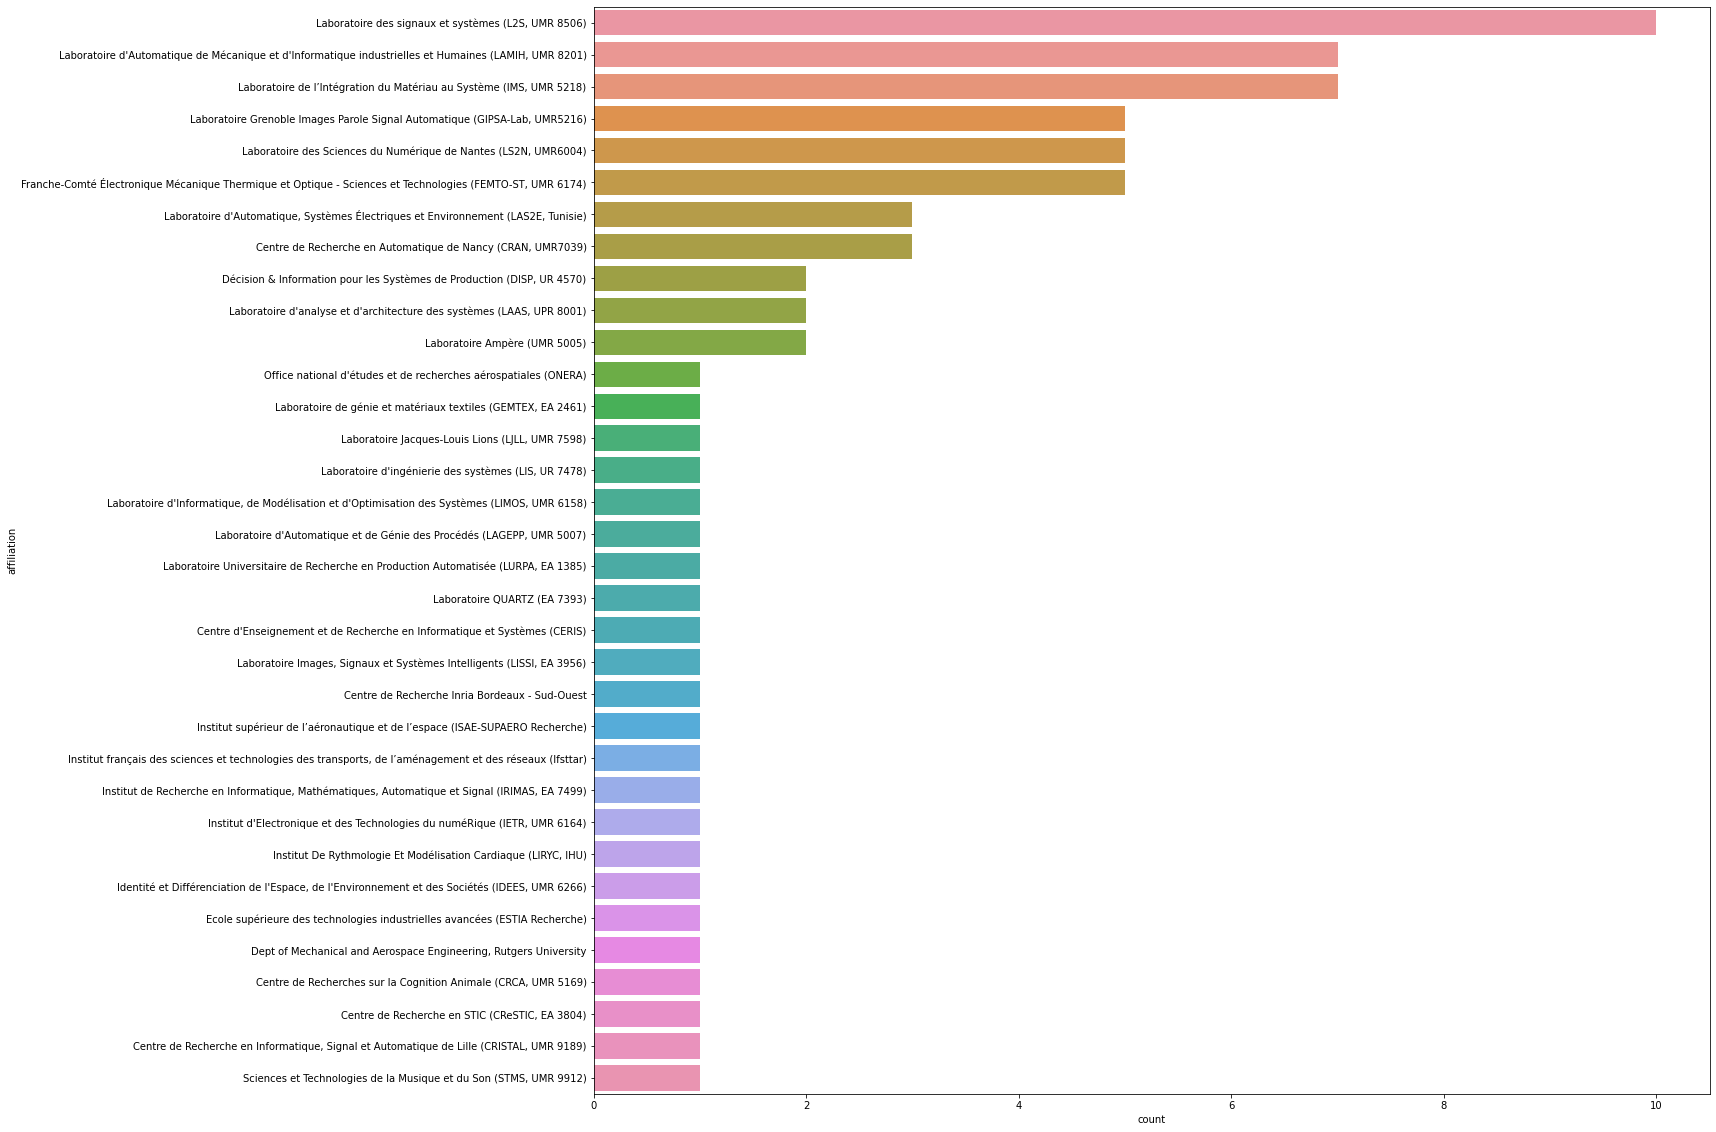

In [44]:
plt.figure(figsize=(20,20))
sns.countplot(y="affiliation",
              order = question_df.groupby(['affiliation']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).affiliation,
              data=question_df)


#### Add city for each lab

In [47]:
# rename duplicates/common formatting: 
lab_city = {'Laboratoire des signaux et systèmes (L2S, UMR 8506)':'91190, Gif-sur-Yvette',
            'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)': "33400, Talence",
            'Décision & Information pour les Systèmes de Production (DISP, UR 4570)': "69621, Villeurbanne",
            'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)': "38400, Saint-Martin-d'Hères",
            'Centre de Recherche en STIC (CReSTIC, EA 3804)': "51100, Reims",
            'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)': "59056, Roubaix",
            'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)':"94400, Vitry-sur-Seine",
            "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)":'59313, Valenciennes',
            "Laboratoire d'ingénierie des systèmes (LIS, UR 7478)": '14032, Caen',
            "Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)": '63178, Aubière',
            'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)':'44322, Nantes',
            'Laboratoire Ampère (UMR 5005)':'69130, Écully',
            'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)':'54506, Vandoeuvre-lès-Nancy',
            "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)":'30100, Alès',
            'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)': '91190, Gif-sur-Yvette',
            "Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)":"59666, Villeneuve d'Ascq",
            "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)": "Monastir, Tunisia",
            "Dept of Mechanical and Aerospace Engineering, Rutgers University":"New Brunswick, NJ, USA",
            'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)': "31400, Toulouse",
            "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)":"31400, Toulouse",
            "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)": "31400, Toulouse",
            "Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)": "64210, Bidart",
            'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)':'68100, Mulhouse',
            'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)':'33600, Pessac',
            'Centre de Recherche Inria Bordeaux - Sud-Ouest':'33405, Talence',
            "Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)": '35510, Cesson-Sévigné',
            "Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)":"75005, Paris",
            "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)":'25000, Besançon',
            "Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)":"59655, Villeneuve-d'Ascq",
            "Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)":"69622, Villeurbanne",
            "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)":'75004, Paris',
            "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)":'76063, Le Havre',
            "Office national d'études et de recherches aérospatiales (ONERA)":"91120, Palaiseau",
            "Laboratoire QUARTZ (EA 7393)": "93400, Saint-Ouen-sur-Seine"}
question_df['city'] = question_df.affiliation.apply(lambda row: lab_city[row]) 

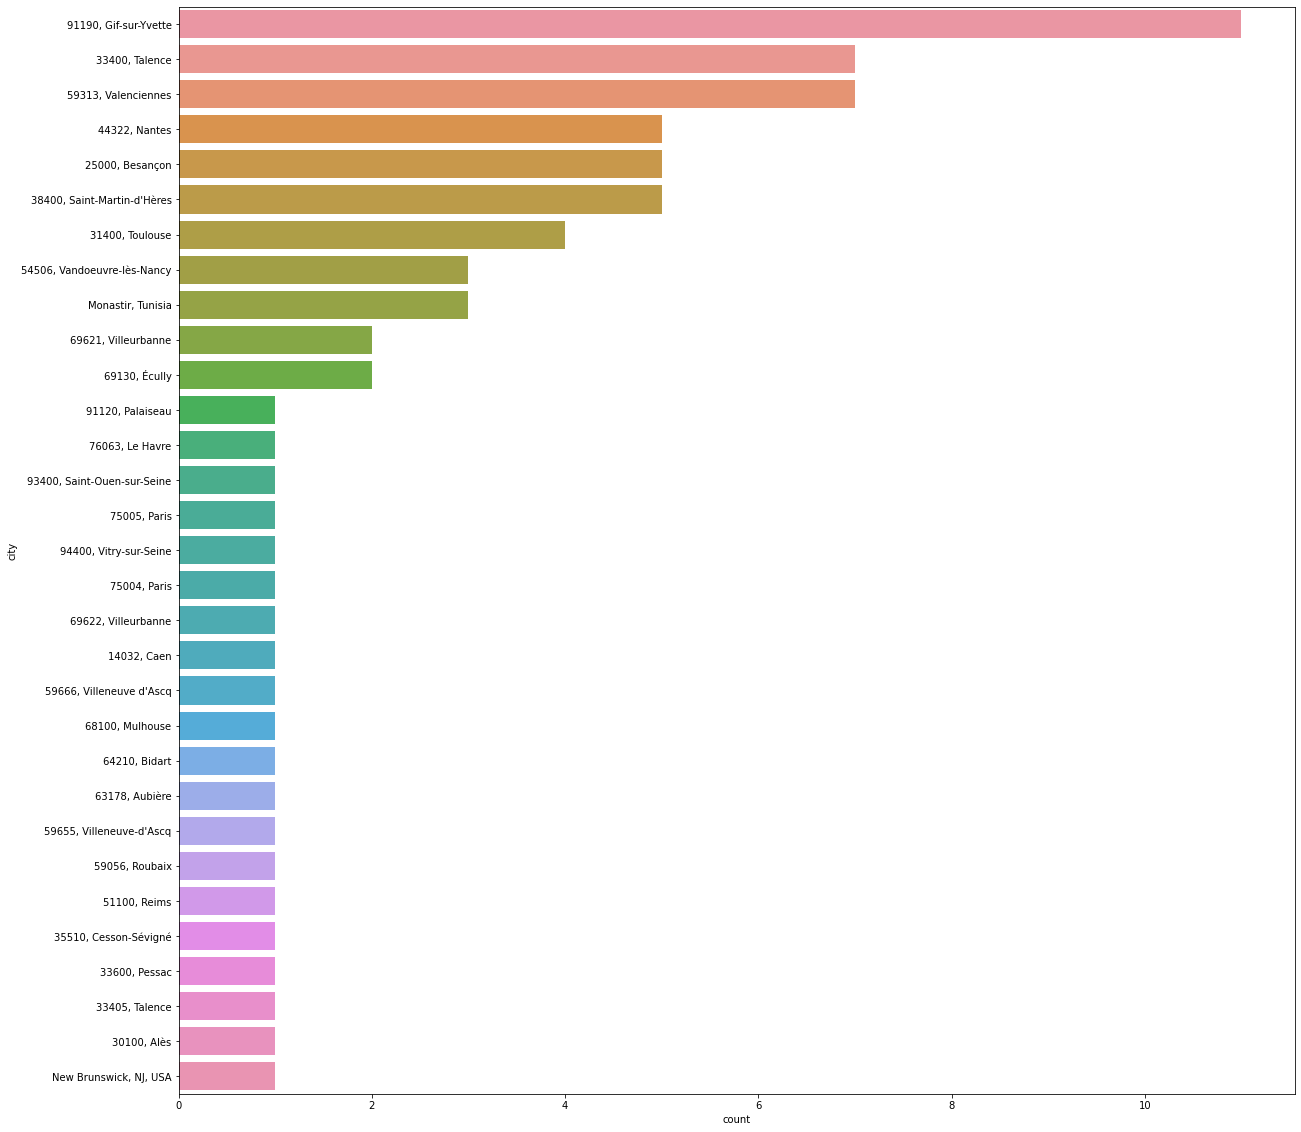

In [48]:
plt.figure(figsize=(20,20))
sns.countplot(y="city",
              order = question_df.groupby(['city']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).city,
              data=question_df)


### Parse categories from multiple-choice questions

#### Clinical domains

In [49]:
# split list in each column and explode as separate rows 
question_df.clinical_domains = question_df.clinical_domains.str.split(',')
question_df= question_df.explode('clinical_domains')

In [52]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Les neurosciences ou la psychatrie':'Neurosciences',
                           'Le systÃ¨me cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           "L'Ã©pidÃ©miologie ou la santÃ© environnementale":'Epidémiologie & Infectiologie',
                           " l'organisation des systÃ¨mes des urgences":'Organisation des soins',
                           ' La cancÃ©rologie':'Cancer',
                           " L'anesthÃ©sie": 'Anesthésie',
                           'Le diabÃ¨te': 'Diabète',
                           'Les sciences du mouvement': 'Mouvement & Musculo-squelettique',
                           " L'Ã©pidÃ©miologie ou la santÃ© environnementale":'Epidémiologie',
                           ' pÃ©diatrie-maternitÃ©': 'Pédiatrie & Obstétrique', 
                           " La vision ou l'ophtalmologie": 'Ophtalmologie',
                           ' supply chain pharmaceutique': 'Pharmacaceutique',
                           ' gestion des patients': 'Organisation des soins',
                           ' Le systÃ¨me cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           ' Les sciences du mouvement':'Mouvement & Musculo-squelettique',
                           ' La biochimie ou la biologie cellulaire Ã\xa0 visÃ©e translationnelle':'Biologie cellulaire',
                           ' Le diabÃ¨te': 'Diabète',
                           ' Les prothÃ¨ses':'Mouvement & Musculo-squelettique',
                           ' IngÃ©nierie et gestion es opÃ©rations de la production de soins': 'Organisation des soins',
                           'La cancÃ©rologie': 'Cancer',
                           ' infectiologie (VIH)': 'Epidémiologie & Infectiologie',
                           'simulation haptique pÃ©dagogique (accouchement': 'Robotique médicale & chirurgie', 
                           ' pÃ©ridurale':np.nan, ' neurochir)':np.nan, #multiple lines
                           'Exosquelette pour rÃ©Ã©ducation et les personnes Ã\xa0 mobilitÃ© rÃ©duite': 'Mouvement & Musculo-squelettique',
                           'ModÃ©lisation des habitudes de vie': np.nan,
                           ' dÃ©tection des dÃ©viations de comportement':'Mouvement & Musculo-squelettique',
                           ' Localisation indoor': np.nan,
                           " Estimation de l'attitude et role dans la classification de mouvement humain Ã\xa0 l'aide de capteurs inertiels et magnÃ©tiques": 'Mouvement & Musculo-squelettique',
                           "La vision ou l'ophtalmologie": 'Ophtalmologie',
                           " SystÃ¨mes d'aide Ã\xa0 la prise de dÃ©cision pour le diagnostic mÃ©dical": 'Organisation des soins',
                           "L'ORL ou l'audition": 'ORL',
                           ' La robotique biomÃ©dicale': 'Robotique médicale & Chirurgie',
                           'Optimisation des organisations hospitaliÃ¨res (GÃ©nie Industriel)': 'Organisation des soins',
                           'La robotique biomÃ©dicale': 'Robotique médicale & chirurgie',
                           "L'anesthÃ©sie": 'Anesthésie',
                           "Assistance Ã\xa0 l'humain (robotique de rÃ©Ã©ducation":  'Robotique médicale & chirurgie',
                           ' diagnostic automatisÃ©...) ':np.nan, 
                           'rien':np.nan, 
                           ' Cardiologie':'Cardio-respiratoire',
                           'maladies infectieuses':'Epidémiologie & Infectiologie',
                           ' ModÃ©lisation muscle':'Mouvement & Musculo-squelettique',
                           ' MÃ©ditation':'Méditation',
                           'gestion des services':'Organisation des soins',
                           ' ThÃ©rapeutique': np.nan,
                           ' Ethique MÃ©dical':'Ethique',
                           "apprentissage ML sur des EEG pour dÃ©tecter la Maladie de Parkinson et d'Alzheimer":'Neurosciences'}
question_df.clinical_domains = question_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   


KeyError: 'Neurosciences'

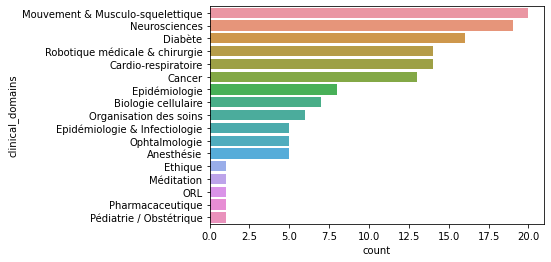

In [51]:
sns.countplot(y="clinical_domains", 
              order = question_df.groupby(['clinical_domains']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).clinical_domains,
              
              data=question_df)

#### Control domains

In [53]:
# split list in each column and explode as separate rows 
question_df.control_domains = question_df.control_domains.str.split(',')
question_df = question_df.explode('control_domains')

In [54]:
question_df.control_domains.unique()

array(['ModÃ©lisation', ' Analyse', ' Commande', ' Observateurs',
       ' Identification', 'Commande', ' capteurs souples',
       ' wearable system', ' systÃ¨me expert', ' optimisation',
       ' Apprentissage ', ' diagnostic', 'Observateurs',
       ' Filtres de kalman', ' IA et Softcomputing', ' Optimisation',
       ' Simulation et Intelligence Artificielle', 'Identification',
       ' optimisation multi-objectifs',
       "En tant que pÃ¨re d'une enfant diabÃ©tique de type 1",
       " je me suis intÃ©ressÃ© aux approches d'ingÃ©nieries et scientifiques sur le domaine",
       'rien', ' Traitement du signal', 'Analyse',
       ' Design and fabrication', ' Machine Learning'], dtype=object)

In [55]:
# rename duplicates: white space and accents
rename_control_domains = {'ModÃ©lisation':'Modélisation',
                          ' Analyse':'Analyse',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Identification':'Identification',
                          'Commande':'Commande',
                          ' capteurs souples':'Autre (capteurs)',
                          ' wearable system': 'Autre (capteurs)',
                          ' systÃ¨me expert': 'Autre (apprentissage machine / IA)',
                          ' optimisation': 'Autre (optimisation)',
                          ' Apprentissage ':'Autre (apprentissage machine / IA)',
                          ' diagnostic':'Autre (apprentissage machine / IA)',
                          'Observateurs':'Observateurs',
                          ' Filtres de kalman':'Modélisation',
                          ' IA et Softcomputing':'Autre (apprentissage machine / IA)',
                          ' Optimisation':'Autre (optimisation)',
                          ' Simulation et Intelligence Artificielle': 'Autre (apprentissage machine / IA)',
                          'Identification':'Identification',
                          ' optimisation multi-objectifs': 'Autre (optimisation)',
                          "En tant que pÃ¨re d'une enfant diabÃ©tique de type 1":np.nan,
                          " je me suis intÃ©ressÃ© aux approches d'ingÃ©nieries et scientifiques sur le domaine":np.nan,
                          'rien':np.nan,
                          ' Traitement du signal':'Autre (traitement du signal)',
                          'Analyse':'Analyse',
                          ' Design and fabrication':'Autre (fabrication)',
                          ' Machine Learning':'Autre (apprentissage machine / IA)'}
question_df.control_domains = question_df.control_domains.apply(lambda row: rename_control_domains[row])   


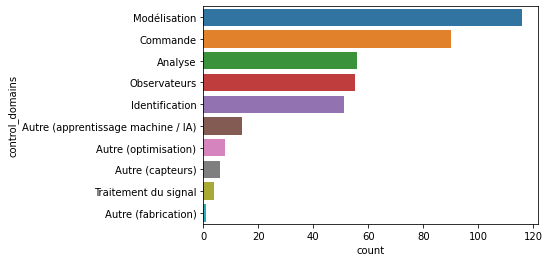

In [56]:
sns.countplot(y="control_domains", 
              order = question_df.groupby(['control_domains']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).control_domains,
              data=question_df)

#### Interests

In [65]:
# split list in each column and explode as separate rows 
question_df.interests = question_df.interests.str.replace(';',',') # some choices are semi-colon separated
question_df.interests = question_df.interests.str.split(',')
question_df = question_df.explode('interests')

In [66]:
question_df.interests.unique()

array(["Etre informÃ© par mail sur des actions scientifiques autour de l'Automatique et de la SantÃ©",
       ' Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me',
       ' Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es',
       ' Contribuer Ã\xa0 des publications communes (livre blanc',
       ' vulgarisation', ' survey', ' confÃ©rences', ' journaux', '...)',
       'Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es',
       'Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me',
       " Animer des sessions sur l'apprentissage du geste mÃ©dical sur simulateur (haptique)",
       ' RÃ©alisation de CongrÃ¨s nationaux et internationaux ',
       ' AccÃ¨s aux donnÃ©es', ' crÃ©er une base',
       ' avoir des subventions pour des stages de M2 ou pour des essais cliniques',
       ' avoir des financements pour conf ou stage '], dtype=object)

In [ ]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_interests = {"Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la santé":'informé par email',
                    ' Participer à des journées scientifiques dédiées':'participer journées scientifiques',
       ' Contribuer à des publications communes (livre blanc': 'participer à des publications',
       ' vulgarisation':np.nan,
        ' survey':np.nan,
        ' conférences':np.nan,
                    ' journaux':np.nan,
                    '...)':np.nan,
       " toute action facilitant l'accès à des practiciens hospitaliers pour conduire des tests cliniques": 'faciliter accès aux médecins',
       ' toute action permettant de trouver des étudiants candidats à stages de master et thèse sur la thématique. . ':'faciliter recrutement étudiants',
       ' Avoir accès à un site web recensant les activités sur ce thèmes':'site web dédié',
        ' Accès aux données':'faciliter accès aux données',
        ' créer une base de données pour échange':'faciliter accès aux médecins',
                    ' opportunités de collaborations aves des médecins':np.nan,
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés'}
manifest_df.interests = manifest_df.interests.apply(lambda row: rename_interests[row])   

# drop nans
manifest_df = manifest_df.dropna(subset=['interests'])


In [ ]:
sns.countplot(y="interests",
              order = manifest_df.groupby(['interests']).last_name.count().reset_index().sort_values(by='last_name',
                                                                                                     ascending=False).interests,
              data=manifest_df)

#### Pain points

In [ ]:
question_df.pain_points.unique()